### Student Information
Name: Mequanent Argaw Muluneh - (倫 莫)

Student ID: 110761504

### Instructions

1. __This part is worth 30% of your grade.__ 

Do the **take home** exercises in the [Lab](Text_Classification_Lab.ipynb). You may need to copy some cells from the Lab notebook to this notebook. 


2. __This part is worth 50% of your grade.__ 

In this lab, we have introduced the basic steps of text classification, including data processing, featrue engineering and model building.
The basic deep learning are introduced in our lab using Keras.
In the class by professor Chen, we have also introduced the more advanced technique of text classification, including RNN, pretrained language model, etc.

In this homework, you are required to build a text classification model using a very popular sequential modeling tecnhique for our SemEval dataset: BERT.
The necessary materials for using BERT are at the official tutorial in the tensorflow [here](https://www.tensorflow.org/text/tutorials/classify_text_with_bert), respectively.

* You need to learn how to adopt the pretrained BERT model and fine-tune on emotion dataset (20%)
* Adopt a DIFFERENT pretrained BERT model and fine-tune TWICE for our task (i.e, transfer learning).  (30%)
Specifically, the first time is to fine-tune the BERT model with **a related dataset** (e.g., the IMDB dataset in the tutorial, since the sentiment classification is similar to emotion classification), and the second time is to fine-tune the BERT model for our SemEval emotion dataset with the fine-tuned model from the first time.

Note that we are encouraging you to try to survey different online resources/tutorials.
The HW is not difficult, try to run these models by yourself on our dataset. 
It is not allowed to just copy the code from your classmates' codes.

3. __This part is worth 20% of your grade.__ 

A report of your work developping the model for HW (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model in the second part. 
You can also mention different things you additional tried and insights you gained. (e.g., the effect of different hyperparameters, the effect of different pretrained language models, etc.) 

Last, it's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add detailed comments and idea for your code**.



Zip two notebook files in a zip file (your_name.zip) and email to TA's at yenhao0218@gapp.nthu.edu.tw  __BEFORE the deadline (Jan 6th)__. 

In [ ]:
### Begin Assignment Here

# Install some libraries

In [1]:
# Install transformers from hugging face for better use of BERT Modules
!pip install -q transformers 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.8 MB/s eta 0:00:00


# Impoort Dependencies

In [2]:
#@title Import Libraries 
%matplotlib inline
import os
import time
import pandas as pd
import numpy as np

#import transformers 
#from transformers import BertModel, BertTokenizer
from transformers import DistilBertModel, DistilBertTokenizer
import torch 
from torch import nn 
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore') 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [3]:
# cloning to access the dataset from github
#!npx degit https://github.com/mequanent/Social-Networks -f

npx: installed 1 in 2.426s
> destination directory is not empty. Using --force, continuing
> cloned mequanent/Social-Networks#HEAD


# SemEval Dataset

In [4]:
#@title Dataset Folder
# show the folder 
#data_folder = "/content/drive/MyDrive/text_lab" # when running with drive data
data_folder = "/content/text_lab" # when running with github data
#os.listdir(data_folder) 

In [ ]:
#@title Read training data
columns = ["id", "text", "emotion", "intensity"]
anger_train = pd.read_csv(f"{data_folder}/data/semeval/train/anger-ratings-0to1.train.txt", 
                          sep="\t", header=None, names=columns)
sadness_train = pd.read_csv(f"{data_folder}/data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=columns)
fear_train = pd.read_csv(f"{data_folder}/data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=columns)
joy_train = pd.read_csv(f"{data_folder}/data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=columns)

# combine 4 sub-dataset, 'se_' prefix to identify from imdb
se_train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [ ]:
#@title Read testing data
anger_test = pd.read_csv(f"{data_folder}/data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=columns)
sadness_test = pd.read_csv(f"{data_folder}/data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=columns)
fear_test = pd.read_csv(f"{data_folder}/data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=columns)
joy_test = pd.read_csv(f"{data_folder}/data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=columns)

# combine 4 sub-dataset
se_test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
se_test_df.head(2)

,id,text,emotion,intensity
0,10857,@ZubairSabirPTI pls dont insult the word 'Molna',anger,0.479
1,10858,@ArcticFantasy I would have almost took offens...,anger,0.458


In [ ]:
# shuffle dataset
se_train_df = se_train_df.sample(frac=1)
se_test_df = se_test_df.sample(frac=1)

In [ ]:
## save to pickle file
se_train_df.to_pickle(os.path.join(data_folder, "se_train_df.pkl")) 
se_test_df.to_pickle(os.path.join(data_folder, "se_test_df.pkl"))

In [5]:
#@title Load a pickle file
se_train_df = pd.read_pickle(os.path.join(data_folder, "se_train_df.pkl"))
se_test_df = pd.read_pickle(os.path.join(data_folder, "se_test_df.pkl"))

In [14]:
# get some validation data from the training set
se_train_df, se_val_df = train_test_split(se_train_df, test_size=0.15, random_state=42)
print("Shape of Training df: ", se_train_df.shape)
print("Shape of Validating df: ", se_val_df.shape)
print("Shape of Testing df: ", se_test_df.shape)

Shape of Training df:  (3071, 4)
Shape of Validating df:  (542, 4)
Shape of Testing df:  (347, 4)


## Learning/practicing subsection

For multi-label text classification learned from [this kaggle notebook](https://www.kaggle.com/sainijagjit/bbc-dataset) on bbc news classification.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sample = 'Hi, this is a sample sentence to learn from BERT.'
# truncation : if it is True then we allow bert to truncated every sequence it's length is higher then max_length
# return_tensors : the type of tensors that will be returned (as we are using pytorch then we set "pt")
bert_input  = tokenizer(sample,padding="max_length",max_length=15,truncation=True,return_tensors="pt")

In [ ]:
bert_input

{'input_ids': tensor([[ 101, 8790,  117, 1142, 1110,  170, 6876, 5650, 1106, 3858, 1121,  139,
         9637, 1942,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
print(bert_input["input_ids"])
# input_ids are the id representation of each token 
# we can decode these inputs to get the original sequence 
print(tokenizer.decode(bert_input["input_ids"][0] ))
# the code 102 is for the [SEP] token and the 0 is for [PAD] token 

tensor([[ 101, 8790,  117, 1142, 1110,  170, 6876, 5650, 1106, 3858, 1121,  139,
         9637, 1942,  102]])
[CLS] Hi, this is a sample sentence to learn from BERT [SEP]


In [ ]:
print(bert_input["token_type_ids"])
# the token_type_ids identified to which sequence a token belongs, when having just one sequence so it's always 0 

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
print(bert_input["attention_mask"]) 
# the attention_mask identified whether the token is a real word or just a token padding
# it's 1 for the real words, the CLS and the SEP tokens, and for the pad token is 0

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


# **Common Classes and Helper Functions**
This section contains `classes` and `helper functions` that can be applied for both the SemEval and IMDB Datasets

## **Label encoder decoder function**

In [ ]:
# how to get the labels from a df, example
labels = list(se_train_df.emotion.unique())
labels

['joy', 'fear', 'sadness', 'anger']

In [6]:
#@title Label encoder decoder function for both imdb and semeval
def encode_decode_labels(df): 
  '''
  +) for SemEval: encoded_labels = {'fear':0, 'sadness':1, 'anger':2, 'joy':3}
  +) for   IMDB:  encoded_labels = {'pos':0, 'neg':1}

  +) for SemEval: decoded_labels = {0:'fear', 1:'sadness', 2:'anger', 3:'joy'}
  +) for   IMDB:  decoded_labels = {0:'pos', 1:'neg'}
  '''
  labels = df.emotion.unique() 
  encoded_labels = {labels[i]: i for i in range(len(labels))}  
  decoded_labels = {v:k for k,v in encoded_labels.items()} # decode the labels 
  return encoded_labels, decoded_labels   

In [ ]:
# showcase example for encode_decode_labels(df)
se_labels, se_decoded_labels = encode_decode_labels(se_test_df)
print('encoded labels: ', se_labels)
print('decoded labels: ', se_decoded_labels) 

encoded labels:  {'joy': 0, 'anger': 1, 'fear': 2, 'sadness': 3}
decoded labels:  {0: 'joy', 1: 'anger', 2: 'fear', 3: 'sadness'}


The encoded labels are used in the training phase and the decoded labels are used to display what the model will predict on the given sentences.

## Dataset Class
**Dataset Class** \
After knowing the outputs of the bert tokenizer, it is possible to build a COMMON Dataset Class for BOTH our SemEval emotion dataset and the IMDB movie review dataset.

In [7]:
#@title Dataset Class
#tokenizer= BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', 
                                                truncation=True, 
                                                do_lower_case=True)
class Dataset(Dataset): 
    def __init__(self, df): 
        '''get the encoded labels from the dataframe 
            +) for SemEval: labels = {'fear':0, 'sadness':1, 'anger':2, 'joy':3}
            +) for   IMDB:  labels = {'pos':0, 'neg':1} 
         +) encode_decode_labels() is a custom function defined above.
         '''
        encoded_labels, _ = encode_decode_labels(df) 
        #extract our labels from the df 
        self.labels = [encoded_labels[label] for label in df["emotion"]]
        
        #extract our labels from the df 
        #self.labels = [sem_eval_labels[label] for label in df["emotion"]]
        #tokenize our texts to the format that BERT expects to get as input 
        self.texts = [tokenizer(text, padding='max_length', max_length=512, 
                                truncation=True, return_tensors="pt")  
                     for text in df["text"]] 
    def classes(self):
        return self.labels
    
    def __len__(self): 
        return len(self.labels)
    
    #fetch a batch of labels
    def get_batch_labels(self,indx): 
        return np.array(self.labels[indx])
    # fetch a batch of texts 
    def get_batch_texts(self,indx): 
        return self.texts[indx]

    #get an item with the texts and the label
    def __getitem__(self, indx): 
        batch_texts = self.get_batch_texts(indx)
        batch_y = self.get_batch_labels(indx)
        
        return batch_texts, batch_y

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Fine Tune BERT
A faster version of BERT, `DistilBertModel`, is prefereed after observing longer training time by using `bert-base-cased` from `BertModel` module in hugging face `transformers`. 

I first tried with `'bert-base-cased'`. Since its training time is longer and searching for faster pre-trained model, I obtained the above `'distilbert-base-uncased'`.

In [8]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
#@title DistilBertSentimentClassifier Model
class DistilBertSentimentClassifier(nn.Module): 
    def __init__(self, n_classes, dropout=0.5): 
        super(DistilBertSentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(768, n_classes)

    def forward(self, input_id, mask):
        output_1 = self.bert(input_ids=input_id, attention_mask=mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

❗❗❗ 
The following `BertSentimentClassifier` class is updated by the above one. To use it, it may need to uncomment its corresponding dependencies. \
There are some displays down below run from it initially and I opt to keep it from deleting.

In [ ]:
#@title BertSentimentClassifier Model
class BertSentimentClassifier(nn.Module): 
    def __init__(self, n_classes, dropout=0.5): 
        super(BertSentimentClassifier, self).__init__()
        
        #self.bert = BertModel.from_pretrained("bert-base-cased")
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        # bert output a vector of size 768 
        #self.lin = nn.Linear(768, 4)
        self.lin = nn.Linear(self.bert.config.hidden_size, n_classes)
        #self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    def forward(self, input_id, mask): 
        # as output, the bert model give us first the embedding vector of all the tokens of the sequence 
        # second we get the embedding vector of the CLS token.
        # fot a classification task it's enough to use this embedding for our classifier

        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
        
        _, pooled_output = self.bert(input_ids=input_id, 
                                    attention_mask = mask, return_dict = False)
        dropout_output = self.dropout(pooled_output)
        linear_output  = self.lin(dropout_output)
        final_layer = self.softmax(linear_output)
        
        return final_layer  

In [9]:
#@title Training Function
''' This training function can take both the datasets and train the network
    since the Dataset function is also common for both
''''

def train(model, train_data, val_data, learning_rate, epochs=5):
  start = time.time()
  #creating a custom Dataset objects using the training and validation data
  train, val = Dataset(train_data), Dataset(val_data)
  #creating dataloaders
  train_dataloader = DataLoader(train, batch_size=2, shuffle=True)
  val_dataloader = DataLoader(val, batch_size=2)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

  if use_cuda:
    model = model.cuda()
    loss = loss.cuda()

  for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    
    for train_input, train_label in tqdm(train_dataloader):
      train_label = train_label.to(device)
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)
      
      # get the predictions
      output = model(input_id, mask)
      
      batch_loss = loss(output, train_label)
      total_loss_train += batch_loss.item()
      
      acc = (output.argmax(dim=1) == train_label).sum().item()
      total_acc_train += acc
      # updating the Gradient Descent and Backpropagation operation
      model.zero_grad()
      batch_loss.backward()
      optimizer.step()
      # now we evaluate on the validation data
      total_acc_val = 0
      total_loss_val = 0
      with torch.no_grad():
        for val_input, val_label in val_dataloader:
          val_label = val_label.to(device)
          mask = val_input['attention_mask'].to(device)
          input_id = val_input['input_ids'].squeeze(1).to(device)
          
          output = model(input_id, mask)
          
          batch_loss = loss(output, val_label)
          total_loss_val += batch_loss.item()
          
          acc = (output.argmax(dim=1) == val_label).sum().item()
          total_acc_val += acc
    print(
        f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
        | Train Accuracy: {total_acc_train / len(train_data): .3f} \
        | Val Loss: {total_loss_val / len(val_data): .3f} \
        | Val Accuracy: {total_acc_val / len(val_data): .3f}')
  print(f'\nTraining time is: {(time.time()-start)/3600: .3f} hrs.')                

In [10]:
#@title Evaluating function

def evaluate(model, test_df):
  ''' This method will test the performance of the trained model with unseen test dataset.
      The unseen dataset will be preprocessed by the above customized
      'Dataset' class
  '''
  test = Dataset(test_df)
  test_dl = DataLoader(test, batch_size=2)
    
  cuda_available = torch.cuda.is_available()
    
  device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
  if cuda_available:
    model = model.cuda()
    
  total_acc = 0
  for test_input, test_label in tqdm(test_dl):
    test_label = test_label.to(device)
    mask = test_input["attention_mask"].to(device)
    input_id = test_input["input_ids"].squeeze(1).to(device) 
    output = model(input_id, mask)
    
    acc = (output.argmax(dim=1) == test_label).sum().item()
    total_acc +=acc 
        
  print(f"\nTest Accuracy : {total_acc / len(test_df): .3f}")    

In [11]:
#@title Prediction Function

def predict(device, model, decoded_labels, sentence):
  ''' This method takes the model, the decoded labels and a sentence.
  The Bert tokenizer will preprocess the input sentence to get the ids of tokens
  and the attention masks.
  It displays the predicted emotion category.
  The method will run on GPU if selected.
  '''
  sentence_input = tokenizer(sentence, padding='max_length', max_length=512,
                             truncation=True,return_tensors="pt").to(device)
  input_id = sentence_input["input_ids"]
  mask = sentence_input["attention_mask"]
  output = model(input_id, mask)
  predicted_class_label = output.argmax(dim=1)
  predicted_class = decoded_labels[predicted_class_label.item()]
  print(f"The predicted emotion is : {predicted_class}")

In [12]:
#@title Predict on df samples function

# This is to test with sample texts from the test set 
def predict_on_samples_from_df(model, df, n_samples):
    # get the labels from the dataframe  
  _, decoded_labels = encode_decode_labels(df)
  # get n_samples of text from the df/test_df
  textset = df.sample(n_samples).reset_index(drop=True)
  
  for i in range(len(textset)):
      text = textset.loc[i, 'text']
      emotion = textset.loc[i, 'emotion']
      print('Predict the following text:\n')
      print(text)
      print('='*50)
      predict(device, model, decoded_labels, text)
      print('The exact emotion is: ', emotion)
      print('+'*50, '\n')      

# BERT for SemEval Dataset

In [16]:
#@title Create and Train Model

# sem_eval_model = BertSentimentClassifier(n_classes=4)
sem_eval_model = DistilBertSentimentClassifier(n_classes=4)
EPOCHS = 10 
learning_rate = 1e-6 
train(sem_eval_model, se_train_df, se_val_df, learning_rate, EPOCHS)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1536/1536 [02:48<00:00,  9.11it/s]


Epochs: 1 | Train Loss:  0.687                 | Train Accuracy:  0.301                 | Val Loss:  0.714                 | Val Accuracy:  0.212


100%|██████████| 1536/1536 [02:47<00:00,  9.17it/s]


Epochs: 2 | Train Loss:  0.644                 | Train Accuracy:  0.423                 | Val Loss:  0.782                 | Val Accuracy:  0.114


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 3 | Train Loss:  0.512                 | Train Accuracy:  0.630                 | Val Loss:  1.022                 | Val Accuracy:  0.090


100%|██████████| 1536/1536 [02:47<00:00,  9.17it/s]


Epochs: 4 | Train Loss:  0.371                 | Train Accuracy:  0.765                 | Val Loss:  1.256                 | Val Accuracy:  0.076


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 5 | Train Loss:  0.282                 | Train Accuracy:  0.823                 | Val Loss:  1.433                 | Val Accuracy:  0.072


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 6 | Train Loss:  0.223                 | Train Accuracy:  0.863                 | Val Loss:  1.578                 | Val Accuracy:  0.074


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 7 | Train Loss:  0.179                 | Train Accuracy:  0.894                 | Val Loss:  1.719                 | Val Accuracy:  0.074


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 8 | Train Loss:  0.146                 | Train Accuracy:  0.913                 | Val Loss:  1.822                 | Val Accuracy:  0.063


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 9 | Train Loss:  0.118                 | Train Accuracy:  0.930                 | Val Loss:  1.916                 | Val Accuracy:  0.072


100%|██████████| 1536/1536 [02:47<00:00,  9.17it/s]


Epochs: 10 | Train Loss:  0.095                 | Train Accuracy:  0.944                 | Val Loss:  2.038                 | Val Accuracy:  0.068

Training time is:  0.491 hrs.


In [ ]:
EPOCHS = 20 # 9:54 am - 10:56 am (time measurement added to code after this run)
#sem_eval_model = BertSentimentClassifier(n_classes=4)
sem_eval_model = DistilBertSentimentClassifier(n_classes=4)

learning_rate = 1e-6 
train(sem_eval_model, se_train_df, se_val_df, learning_rate, EPOCHS)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1536/1536 [02:53<00:00,  8.85it/s]


Epochs: 1 | Train Loss:  0.689                 | Train Accuracy:  0.293                 | Val Loss:  0.711                 | Val Accuracy:  0.214


100%|██████████| 1536/1536 [02:52<00:00,  8.88it/s]


Epochs: 2 | Train Loss:  0.682                 | Train Accuracy:  0.322                 | Val Loss:  0.716                 | Val Accuracy:  0.205


100%|██████████| 1536/1536 [02:53<00:00,  8.88it/s]


Epochs: 3 | Train Loss:  0.668                 | Train Accuracy:  0.355                 | Val Loss:  0.752                 | Val Accuracy:  0.199


100%|██████████| 1536/1536 [02:53<00:00,  8.87it/s]


Epochs: 4 | Train Loss:  0.634                 | Train Accuracy:  0.416                 | Val Loss:  0.784                 | Val Accuracy:  0.181


100%|██████████| 1536/1536 [02:52<00:00,  8.88it/s]


Epochs: 5 | Train Loss:  0.589                 | Train Accuracy:  0.495                 | Val Loss:  0.811                 | Val Accuracy:  0.181


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 6 | Train Loss:  0.534                 | Train Accuracy:  0.568                 | Val Loss:  0.890                 | Val Accuracy:  0.166


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 7 | Train Loss:  0.481                 | Train Accuracy:  0.627                 | Val Loss:  0.984                 | Val Accuracy:  0.175


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 8 | Train Loss:  0.425                 | Train Accuracy:  0.677                 | Val Loss:  1.080                 | Val Accuracy:  0.151


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 9 | Train Loss:  0.376                 | Train Accuracy:  0.718                 | Val Loss:  1.168                 | Val Accuracy:  0.148


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 10 | Train Loss:  0.321                 | Train Accuracy:  0.771                 | Val Loss:  1.281                 | Val Accuracy:  0.151


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 11 | Train Loss:  0.277                 | Train Accuracy:  0.806                 | Val Loss:  1.346                 | Val Accuracy:  0.140


100%|██████████| 1536/1536 [02:53<00:00,  8.86it/s]


Epochs: 12 | Train Loss:  0.237                 | Train Accuracy:  0.838                 | Val Loss:  1.427                 | Val Accuracy:  0.133


100%|██████████| 1536/1536 [02:52<00:00,  8.88it/s]


Epochs: 13 | Train Loss:  0.201                 | Train Accuracy:  0.874                 | Val Loss:  1.570                 | Val Accuracy:  0.114


100%|██████████| 1536/1536 [02:52<00:00,  8.88it/s]


Epochs: 14 | Train Loss:  0.170                 | Train Accuracy:  0.891                 | Val Loss:  1.616                 | Val Accuracy:  0.137


100%|██████████| 1536/1536 [02:52<00:00,  8.88it/s]


Epochs: 15 | Train Loss:  0.142                 | Train Accuracy:  0.918                 | Val Loss:  1.731                 | Val Accuracy:  0.124


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 16 | Train Loss:  0.117                 | Train Accuracy:  0.931                 | Val Loss:  1.807                 | Val Accuracy:  0.120


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 17 | Train Loss:  0.098                 | Train Accuracy:  0.944                 | Val Loss:  1.860                 | Val Accuracy:  0.125


100%|██████████| 1536/1536 [02:52<00:00,  8.88it/s]


Epochs: 18 | Train Loss:  0.085                 | Train Accuracy:  0.952                 | Val Loss:  1.983                 | Val Accuracy:  0.105


100%|██████████| 1536/1536 [02:52<00:00,  8.88it/s]


Epochs: 19 | Train Loss:  0.075                 | Train Accuracy:  0.962                 | Val Loss:  1.986                 | Val Accuracy:  0.127


100%|██████████| 1536/1536 [02:52<00:00,  8.89it/s]


Epochs: 20 | Train Loss:  0.064                 | Train Accuracy:  0.968                 | Val Loss:  2.091                 | Val Accuracy:  0.111


In [18]:
# see the model attributes
sem_eval_model

DistilBertSentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

## Test the model

In [19]:
evaluate(sem_eval_model, se_test_df) # test with unseen dataset

100%|██████████| 174/174 [00:05<00:00, 30.69it/s]


Test Accuracy :  0.256


In [ ]:
evaluate(sem_eval_model, se_test_df) 

100%|██████████| 174/174 [00:06<00:00, 28.20it/s]


Test Accuracy :  0.305


It shows a bit lower accuracy. Let us see it predicting on some sentences as shown below.

In [ ]:
# predict for 5 random sentences from test dataset having a clear label 
predict_on_samples_from_df(sem_eval_model, se_test_df, n_samples=5) 

Predict the following text:

@FluDino Event started! everyone is getting ready to travel to the lake of rage, where everything glows
The predicted emotion is : anger
The exact emotion is:  anger
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

@abra @abra @abra what're you doing to my ears? To my soul?! #GoodMusic #melancholy
The predicted emotion is : sadness
The exact emotion is:  sadness
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

I feel like an appendix. I don't have a purpose.  #depressed  #alone #lonely #broken  #cry #hurt #crying #life
The predicted emotion is : anger
The exact emotion is:  sadness
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

Bout ta get my @dontbreathe on up in here! @WarrenTheaters #nervous #icantholdmybreaththatlong
The predicted emotion is : sadness
The exact emotion is:  fear
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following t

## Predict on Single inputs
We can also test with our own statemnts 

In [ ]:
# we need to input the decoded labels to predict on single sentence inputs
# for the above case, my function handles the decoding from the testing dataframe
_, se_decoded_labels = encode_decode_labels(se_train_df)
se_decoded_labels 

{0: 'joy', 1: 'fear', 2: 'sadness', 3: 'anger'}

In [ ]:
# We may not be sure of the labels for our sentences 
predict(device, sem_eval_model, se_decoded_labels,
        "Your really did great to me. I am proud of you.")

The predicted emotion is : anger


In [ ]:
# 
predict(device, sem_eval_model, se_decoded_labels,
        "Your really did bad to me. I feel sorry.")

The predicted emotion is : anger


In [ ]:
# what if a little modification of the above sentence
predict(device, sem_eval_model, se_decoded_labels,
        "Your really did bad. I feel sad.")

The predicted emotion is : sadness


# **BERT for IMDB Dataset** 

## Download the dataset

In [21]:
# There are many sources of this dataset but this one doesn't require to store
# the data and no need to deal with changing data folders manually. 
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2023-01-09 05:17:32--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  15.3MB/s    in 8.8s    

2023-01-09 05:17:41 (9.13 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



The texts in the IMDB dataset are in separate files with in train/test folders with pos/neg subfolders. The following method will read every line in pos and neg subfolders and assign the subfolder name as a label. 

In [22]:
#@title IMDB -\> DF

# read the imdb dataset into pandas data frame format 
from pathlib import Path 
# 
def read_imdb_data(split_dir): 
    df = pd.DataFrame(columns = ['text', 'emotion']) 
    # while the labels in imdb are called 'label', 'emotion' is used instead 
    # of 'label' to make more similar with SemEval 
    split_dir = Path(split_dir) 

    for label_dir in ["pos", "neg"]: 
        for text_file in (split_dir/label_dir).iterdir(): 
            df = df.append({'text' : text_file.read_text(), 
                            'emotion' : label_dir}, ignore_index = True) 

    return df 

imdb_train_df = read_imdb_data('aclImdb/train') 
imdb_test_df = read_imdb_data('aclImdb/test') 
display(imdb_train_df.head(2)) 
display(imdb_test_df.head(2)) 

,text,emotion
0,***SPOILERS*** ***SPOILERS*** Packed with memo...,pos
1,"""Heartland"" is a wonderful depiction of what i...",pos


,text,emotion
0,This has got to be one of the best episodes of...,pos
1,A sparkling movie. BB is a marvel. She's sultr...,pos


In [23]:
# shuffle the datasets 
imdb_train_df = imdb_train_df.sample(frac=1)
imdb_test_df = imdb_test_df.sample(frac=1)

In [24]:
#@title Save to pickle file 
# to reduce downloading every time, saving to drive may be faster 
imdb_train_df.to_pickle(os.path.join(data_folder, "imdb_train_df.pkl")) 
imdb_test_df.to_pickle(os.path.join(data_folder, "imdb_test_df.pkl")) 

In [25]:
#@title Load a pickle file 
imdb_train_df = pd.read_pickle(os.path.join(data_folder, "imdb_train_df.pkl")) 
imdb_test_df = pd.read_pickle(os.path.join(data_folder, "imdb_test_df.pkl")) 

In [26]:
# get some validation data from the testing set which is 25K
imdb_test_df, imdb_val_df = train_test_split(imdb_test_df, test_size=0.2,
                                              random_state=42)
print("Shape of Training df: ", imdb_train_df.shape)
print("Shape of Validating df: ", imdb_val_df.shape)
print("Shape of Testing df: ", imdb_test_df.shape)

Shape of Training df:  (25000, 2)
Shape of Validating df:  (5000, 2)
Shape of Testing df:  (20000, 2)


## Train Model

In [28]:

EPOCHS = 2 # The dataset is large and takes long to give more epochs
imdb_model = DistilBertSentimentClassifier(n_classes=2)
learning_rate = 1e-6
train(imdb_model, imdb_train_df, imdb_val_df, learning_rate, EPOCHS) 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 12500/12500 [23:23<00:00,  8.91it/s]


Epochs: 1 | Train Loss:  0.149                 | Train Accuracy:  0.875                 | Val Loss:  1.455                 | Val Accuracy:  0.083


100%|██████████| 12500/12500 [23:24<00:00,  8.90it/s]


Epochs: 2 | Train Loss:  0.094                 | Train Accuracy:  0.930                 | Val Loss:  1.731                 | Val Accuracy:  0.076

Training time is:  0.869 hrs.


## Test model

In [29]:
evaluate(imdb_model, imdb_test_df)

100%|██████████| 10000/10000 [05:32<00:00, 30.05it/s]



Test Accuracy :  0.920


This model shows a **better** accuracy than **sem_eval_model**. It may be becuase of the larger training data.

#### Test on `imdb_test_df` Sentences

In [31]:
# predict for 5 random sentences from test dataset
predict_on_samples_from_df(imdb_model, imdb_test_df, n_samples=5)  

Predict the following text:

The trailer for this film promised a new twist on the zombie genre: setting it in the Old West. Except it's not the real Old West, of course. It's some sort of Future West, in a world where some apocalypse has, as apocalypses are known to do, killed people and subsequently turned them into zombies. It's zombie virus time again, folks, and you know what that means? Get bitten and become one of them.<br /><br />So, into this dusty and dead-filled world comes a hero. He's a bounty-hunter, getting paid for taking care of zombies. It's not exactly clear who is providing the funds, but it seems a little cottage industry of zombie-hunting has emerged. But, as the trailer tells us, there's a problem. They are running out of zombies. The only way to keep on earning is to infect new towns and cities with the virus.<br /><br />I think that's not a bad idea for a film. But unfortunately it takes a lot more than a good idea and a crowd of people pawing at windows to mak

#### Test on Single Sentences

In [32]:
_, imdb_decoded_labels = encode_decode_labels(imdb_train_df)
imdb_decoded_labels 

{0: 'neg', 1: 'pos'}

In [ ]:
predict(device, imdb_model, imdb_decoded_labels, 
        "Yesterday's movie was fantastic.")

The predicted emotion is : pos


In [ ]:
predict(device, imdb_model, imdb_decoded_labels, 
        "The sound quality was not good.")

The predicted emotion is : neg


# BERT Transferl Learning:  IMDB -\> SemEval

In [33]:
imdb_model # See the model structure to fine-tune to other dataset

DistilBertSentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

In [34]:
''' We can change the out_features from 2 to 4 to do transfer learning on 
 a bert model first trained by the imdb dataset. After changing the out_features
 attribute of the model, we re-train, validate and test with the SemEval dataset.
'''
imdb_model.classifier, nn.Linear(768, 4)

(Linear(in_features=768, out_features=2, bias=True),
 Linear(in_features=768, out_features=4, bias=True))

## Train `imdb_model` with `se_train_df`

In [35]:
# Train for the same number of epochs as sem_eval_model to compare the difference
EPOCHS = 10 

imdb_model.classifier = nn.Linear(768, 4) # modify the number of output neurons
learning_rate = 1e-6 
# train the modified imdb_model with the semeval data set
train(imdb_model, se_train_df, se_val_df, learning_rate, EPOCHS)

100%|██████████| 1536/1536 [02:48<00:00,  9.12it/s]


Epochs: 1 | Train Loss:  0.664                 | Train Accuracy:  0.371                 | Val Loss:  0.767                 | Val Accuracy:  0.146


100%|██████████| 1536/1536 [02:47<00:00,  9.15it/s]


Epochs: 2 | Train Loss:  0.561                 | Train Accuracy:  0.543                 | Val Loss:  0.908                 | Val Accuracy:  0.120


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 3 | Train Loss:  0.436                 | Train Accuracy:  0.697                 | Val Loss:  1.085                 | Val Accuracy:  0.090


100%|██████████| 1536/1536 [02:47<00:00,  9.17it/s]


Epochs: 4 | Train Loss:  0.330                 | Train Accuracy:  0.788                 | Val Loss:  1.255                 | Val Accuracy:  0.087


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 5 | Train Loss:  0.257                 | Train Accuracy:  0.839                 | Val Loss:  1.398                 | Val Accuracy:  0.081


100%|██████████| 1536/1536 [02:47<00:00,  9.17it/s]


Epochs: 6 | Train Loss:  0.203                 | Train Accuracy:  0.872                 | Val Loss:  1.518                 | Val Accuracy:  0.081


100%|██████████| 1536/1536 [02:47<00:00,  9.17it/s]


Epochs: 7 | Train Loss:  0.165                 | Train Accuracy:  0.902                 | Val Loss:  1.657                 | Val Accuracy:  0.081


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 8 | Train Loss:  0.135                 | Train Accuracy:  0.919                 | Val Loss:  1.761                 | Val Accuracy:  0.077


100%|██████████| 1536/1536 [02:47<00:00,  9.18it/s]


Epochs: 9 | Train Loss:  0.107                 | Train Accuracy:  0.939                 | Val Loss:  1.868                 | Val Accuracy:  0.077


100%|██████████| 1536/1536 [02:47<00:00,  9.19it/s]


Epochs: 10 | Train Loss:  0.086                 | Train Accuracy:  0.953                 | Val Loss:  1.955                 | Val Accuracy:  0.066

Training time is:  0.491 hrs.


## Test with the `se_test_df` 

In [37]:
#evaluate(sem_eval_model, se_test_df) 
evaluate(imdb_model, se_test_df) 

100%|██████████| 174/174 [00:05<00:00, 30.11it/s]


Test Accuracy :  0.245


The accuracy is still low. Let us train the same model with no changes in its structure for more 10 epochs.

In [42]:
EPOCHS = 10 # Train for more 10 epochs

#imdb_model.classifier = nn.Linear(768, 4) # no need to modify here
learning_rate = 1e-6 
# train the modified imdb_model with the semeval data set
train(imdb_model, se_train_df, se_val_df, learning_rate, EPOCHS)

100%|██████████| 1536/1536 [02:48<00:00,  9.12it/s]


Epochs: 1 | Train Loss:  0.068                 | Train Accuracy:  0.960                 | Val Loss:  2.060                 | Val Accuracy:  0.072


100%|██████████| 1536/1536 [02:47<00:00,  9.16it/s]


Epochs: 2 | Train Loss:  0.053                 | Train Accuracy:  0.969                 | Val Loss:  2.158                 | Val Accuracy:  0.068


100%|██████████| 1536/1536 [02:47<00:00,  9.16it/s]


Epochs: 3 | Train Loss:  0.045                 | Train Accuracy:  0.974                 | Val Loss:  2.260                 | Val Accuracy:  0.077


100%|██████████| 1536/1536 [02:47<00:00,  9.17it/s]


Epochs: 4 | Train Loss:  0.038                 | Train Accuracy:  0.976                 | Val Loss:  2.307                 | Val Accuracy:  0.076


100%|██████████| 1536/1536 [02:47<00:00,  9.16it/s]


Epochs: 5 | Train Loss:  0.033                 | Train Accuracy:  0.980                 | Val Loss:  2.399                 | Val Accuracy:  0.081


100%|██████████| 1536/1536 [02:47<00:00,  9.16it/s]


Epochs: 6 | Train Loss:  0.029                 | Train Accuracy:  0.980                 | Val Loss:  2.487                 | Val Accuracy:  0.077


100%|██████████| 1536/1536 [02:47<00:00,  9.17it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  0.980                 | Val Loss:  2.567                 | Val Accuracy:  0.077


100%|██████████| 1536/1536 [02:48<00:00,  9.14it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.981                 | Val Loss:  2.612                 | Val Accuracy:  0.074


100%|██████████| 1536/1536 [02:49<00:00,  9.08it/s]


Epochs: 9 | Train Loss:  0.024                 | Train Accuracy:  0.982                 | Val Loss:  2.683                 | Val Accuracy:  0.076


100%|██████████| 1536/1536 [02:49<00:00,  9.09it/s]


Epochs: 10 | Train Loss:  0.023                 | Train Accuracy:  0.980                 | Val Loss:  2.698                 | Val Accuracy:  0.081

Training time is:  0.492 hrs.


In [43]:
evaluate(imdb_model, se_test_df) 

100%|██████████| 174/174 [00:05<00:00, 30.05it/s]


Test Accuracy :  0.242


It shows a closer accuracy as one with the first ten epochs.

The following two cells are the performance of the base-cased BertModel with only two epochs. It was a better accuracy but requires longer time to train it.

In [ ]:
EPOCHS = 2

imdb_model.lin = nn.Linear(768, 4) # modify the number of output neurons
learning_rate = 1e-6 
# train the modified imdb_model with the semeval data set
train(imdb_model, se_train_df, se_val_df, learning_rate, EPOCHS)

100%|██████████| 1536/1536 [05:24<00:00,  4.73it/s]


Epochs: 1 | Train Loss:  0.670                 | Train Accuracy:  0.376                 | Val Loss:  0.740                 | Val Accuracy:  0.113


100%|██████████| 1536/1536 [05:27<00:00,  4.69it/s]


Epochs: 2 | Train Loss:  0.593                 | Train Accuracy:  0.595                 | Val Loss:  0.764                 | Val Accuracy:  0.133


In [ ]:
#evaluate(sem_eval_model, se_test_df) 
evaluate(imdb_model, se_test_df) 

100%|██████████| 174/174 [00:10<00:00, 16.06it/s]


Test Accuracy :  0.280


We can see from the following cells that the `imdb_model` trained with the semeval dataset is now able to predict four categories. 

In [38]:
# predict for 5 random sentences from semeval test dataset
# The imdb_model is now predicting the emotion of the semeval dataset
predict_on_samples_from_df(imdb_model, se_test_df, n_samples=5) 

Predict the following text:

@LeePorter94 @DomMcGovern_ hi Dom I saw u at Notts county away, looking for 1 mufc away ticket will pay #blues
The predicted emotion is : fear
The exact emotion is:  sadness
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

@MacDsmash you should get some @SSB_Swedish delight
The predicted emotion is : joy
The exact emotion is:  joy
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

im thoroughly in love w zen and jumin and i dont think id even have the patience for either of them irl im old and weary
The predicted emotion is : fear
The exact emotion is:  sadness
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

If Angelina Jolie can't keep a man no one can. Today we mourn because Love is dead
The predicted emotion is : fear
The exact emotion is:  sadness
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

It's the most magical time of

In [ ]:
# predict for 5 random sentences from semeval test dataset
# The imdb_model is now predicting the emotion of the semeval dataset
predict_on_samples_from_df(imdb_model, se_test_df, n_samples=5) 

Predict the following text:

All Brian does is sleep and aggravate me
The predicted emotion is : sadness
The exact emotion is:  anger
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

Sorry guys I have absolutely no idea what time i'll be on cam tomorrow but will keep you posted. #fuming
The predicted emotion is : sadness
The exact emotion is:  anger
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

Whatt a trailerrrr !!! @karanjohar @AnushkaSharma #RanbirKapoor #AishwaryaRaiBachchan i am COMPLETELY BLOWN !! #awestruck #longingformore
The predicted emotion is : joy
The exact emotion is:  fear
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Predict the following text:

@CNNPolitics I can't wait to hear what he had to say about the brilliant Dr. Hawking... it should be rich... In the poorest of taste! 
The predicted emotion is : sadness
The exact emotion is:  fear
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Pre

## User Input Sentences

In [ ]:
_, se_decoded_labels = encode_decode_labels(se_train_df)
se_decoded_labels 
# We can also test with our own statemnts 
#predict(device, sem_eval_model, se_decoded_labels,
predict(device, imdb_model, se_decoded_labels,
        "Your really did great to me. I am proud of you.")

The predicted emotion is : joy


In [41]:
# We can also test with our own statemnts 
predict(device, imdb_model, se_decoded_labels,
        "Your really did bad to me. I feel sorry.")

The predicted emotion is : sadness


In [40]:
# what if a little modification of the above sentence
predict(device, imdb_model, se_decoded_labels,
        "Your really did bad. I feel sad.")

The predicted emotion is : sadness


# End of Part Two

# **Part Three**
**Report**

I tried to add comments and some text sections along with doing the HW. The ***Table of Contents*** also can help more on how I arranged my codes and texts in the text boxes. \
To add a few things: 

*   First, I installed the hugging face transformers to access the BERT modules.
*   Then imported the dependency libraries.
*   After reading the SemEval dataset, I run some exercising cells to see how BERT works and what inputs and outputs it has.
*   I defined a label encoder decoder common function. It takes the dataframe and encodes its emotion category. I renamed the 'sentiment' category of the IMDB dataset to 'emotion' so that I will have the same function for both.
*   My next task was to customize the Dataset Class from pytorch to handle both the SemEval and the IMDB datasets.
*   Then customized the DistilBert and Bert models, also making common to fit with both datasets to reduce code redundancy.
*   After customizing the Bert model, I also have the common training, evaluation and prediction helper functions.
*   After finishing the common parts, I create a Bert model for the SemEval dataset(`sem_eval_model`), train it, and test it.
*   The next task is phase one of part 2 which is fine-tuning Bert for IMDB dataset. For this I downloaded the dataset which is arranged in a different way.\
Its arrangement was like the down below screenshot of the directory. It needs to read every file in each subfolders and make them on row in a dataframe, the subfolders 'pos' and 'neg' being the sentiment category values in the dataframe.\
I prefered this one than the available csv formats so that there will be no need to make datapath changes, download-upload stuffs. 

*   After reading the IMDB dataset, I created another model named `imdb_model` which predicts to two categories, pos and neg. Trained, evaluated and tested it shows a better accuracy than the `sem_eval_model`. 
*   The next task is to do the transfer learning/ second time fine-tuning. For this task, I changed the number of output neurons of the `imdb_model` from 2 to 4 so that it will be re-trained and tested with the SemEval dataset. Trained, evaluated, and tested the modified `imdb_model` with the semeval training, validation, and testing datasets. The observed result shows no significant performance improvement than the `sem_eval_model`. 


I tried to acknowledge some resources I used as refernces by mentioning the links unless there will be forgotten ones. 

**Organization of IMDB Dataset.**

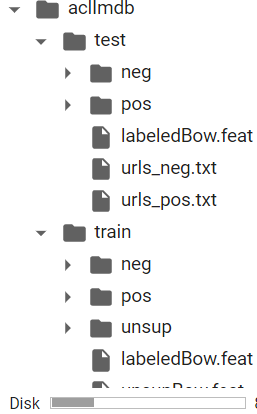 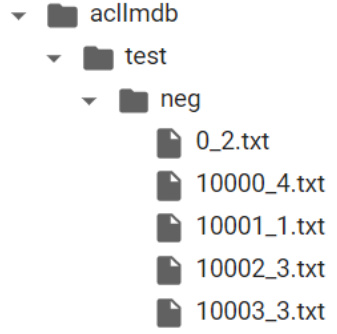